# A translation of the ISCC-NBS Color Naming System into CIELAB Lch

The [ISCC–NBS System of Color Designation](https://en.wikipedia.org/wiki/ISCC%E2%80%93NBS_system) is a system for naming colors based on a set of 12 basic color terms and a small set of adjective modifiers. This system formally defines a set of non-technical color names as a subset of the [Munsell System](https://en.wikipedia.org/wiki/Munsell_color_system), which was an early attempt at measuring color in terms of a hue, value, and chroma.

Unfortunately, converting Munsell to a more present-day conventional system (such as RGB or Lab) [involves interpolation of empirical data in 3D that is highly non-linear](https://stackoverflow.com/a/12556404) and libraries for handling Munsell seem to be few and far between. Which is unfortunate, since the ISCC-NBS naming system seems like a useful categorization scheme.

The Python [Colour Science](https://www.colour-science.org/) library does provide such conversion functionality, and we can use that to renotate and re-bound the color ranges from the ISCC-NBS system.

In [196]:
# But first, we need some things...
import sys
!{sys.executable} -m pip install -q matplotlib colour-science ipympl shapely scipy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [501]:
# Pull in data for the ISCC-NBS system
from colordb import ColorDatabase
import os

colordb = ColorDatabase(os.path.join(os.getcwd(), "..", "iscc-nbs.xml"))

print(colordb.get_descriptor_from_munsell('6P 4.5/11.0').name)

Strong purple


The Munsell color volume can be thought of as a cylinder (or at least cylinder-like). Most of the charts in _The Universal Color Language_ are given as x-y range plots, looking at slices of that cylinder, but we can also present the information in polar form.

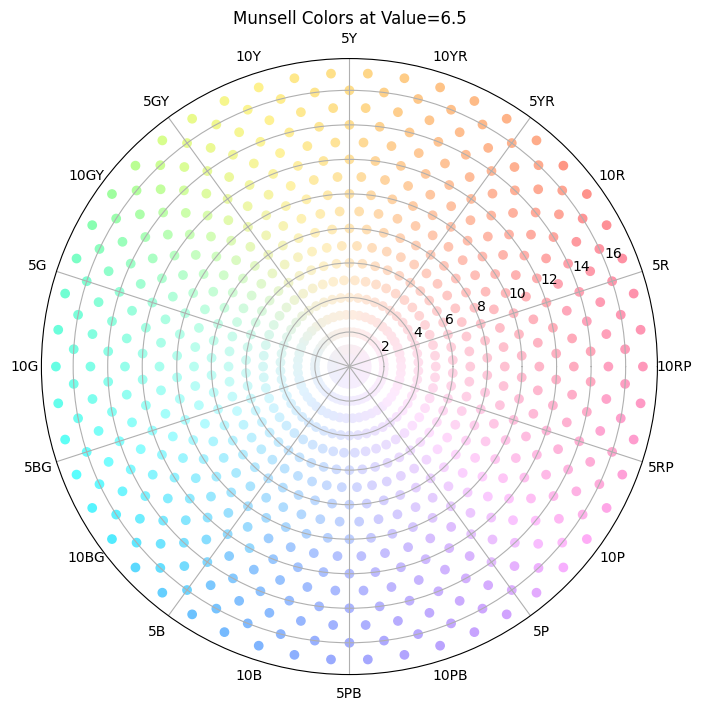

In [199]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import colour
import itertools

from ISCC_NBS_renotations import munsell_to_polar
from ISCC_NBS_renotations import munsell_to_rgbstr
from ISCC_NBS_renotations import set_xticks_munsell_hues

from munsell import munsell_specification_to_munsell_colour

hues = np.arange(1, 10, 2.0)
hues_offset = np.arange(2, 11, 2.0)
hue_codes = range(1, 11)
chromas = [0.25, 0.50, 1.0] + [x for x in np.arange(2, 18, 2.0)]
chromas_offset = np.arange(3, 18, 2.0)
value = 9.5
colors_to_plot = (
    [munsell_specification_to_munsell_colour([*x]) for x in itertools.product(hues, [value], chromas, hue_codes)] +
    [munsell_specification_to_munsell_colour([*x]) for x in itertools.product(hues_offset, [value], chromas_offset, hue_codes)]
)

theta, r = zip(*[munsell_to_polar(x) for x in colors_to_plot])
colors = [munsell_to_rgbstr(x) for x in colors_to_plot]

fig = plt.figure(figsize=[8.0, 8.0])
ax = fig.add_subplot(projection='polar')
set_xticks_munsell_hues(ax)
ax.set_title("Munsell Colors at Value=6.5")
c = ax.scatter(theta, r, c=colors)

We can also group these by what 

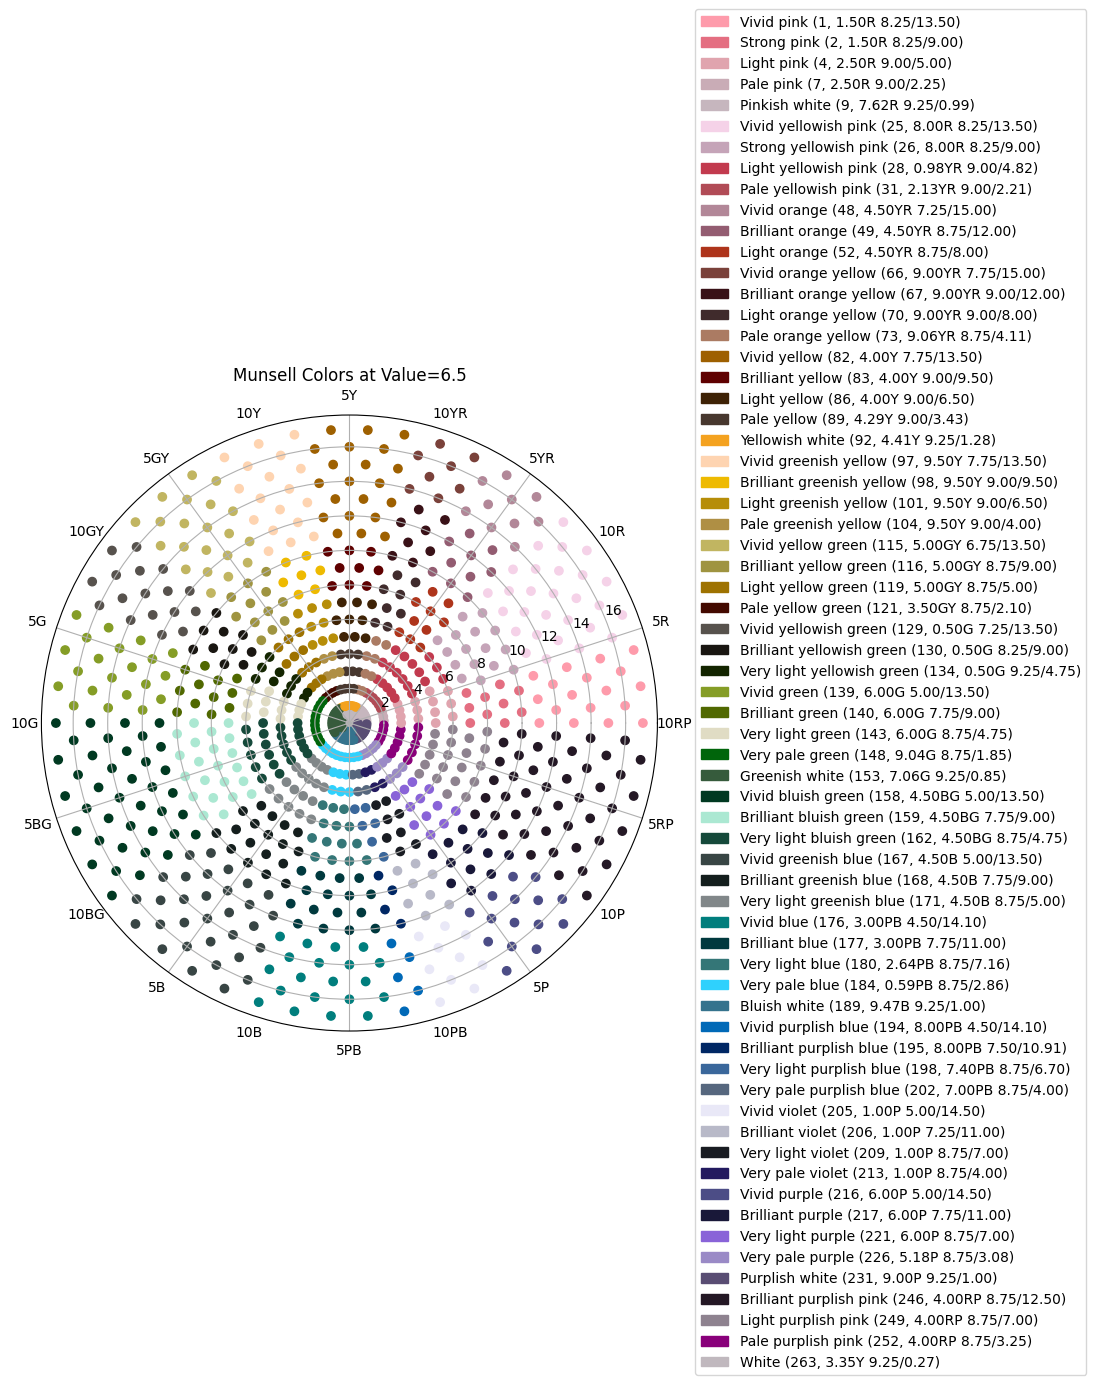

In [200]:
theta, r = zip(*[munsell_to_polar(x) for x in colors_to_plot])

descriptors = [colordb.get_descriptor_from_munsell(x) for x in colors_to_plot]
ids = [x.id for x in descriptors]
unique_ids = list(set(ids))
unique_ids.sort()
color_map = [munsell_to_rgbstr(colordb.get_level3_colors()[id].centroid_color) for id in colordb.get_level3_colors().keys()]
color_labels = ["{} ({}, {})".format(colordb.get_level3_colors()[id].name, id, colordb.get_level3_colors()[id].centroid_color) for id in unique_ids]
color_patches = [mpatches.Patch(color=color_map[unique_ids[i]], label=color_labels[i]) for i in range(0, len(unique_ids))]

color_mapping = [color_map[d.id] for d in descriptors]


fig = plt.figure(figsize=[8.0, 8.0])
ax = fig.add_subplot(projection='polar')
set_xticks_munsell_hues(ax)
ax.set_title("Munsell Colors at Value=6.5")
angle = np.deg2rad(0)
ax.legend(handles=color_patches, loc="center left", bbox_to_anchor=(.55 + np.cos(angle)/2, .55 + np.sin(angle)/2))
c = ax.scatter(theta, r, c=color_mapping)

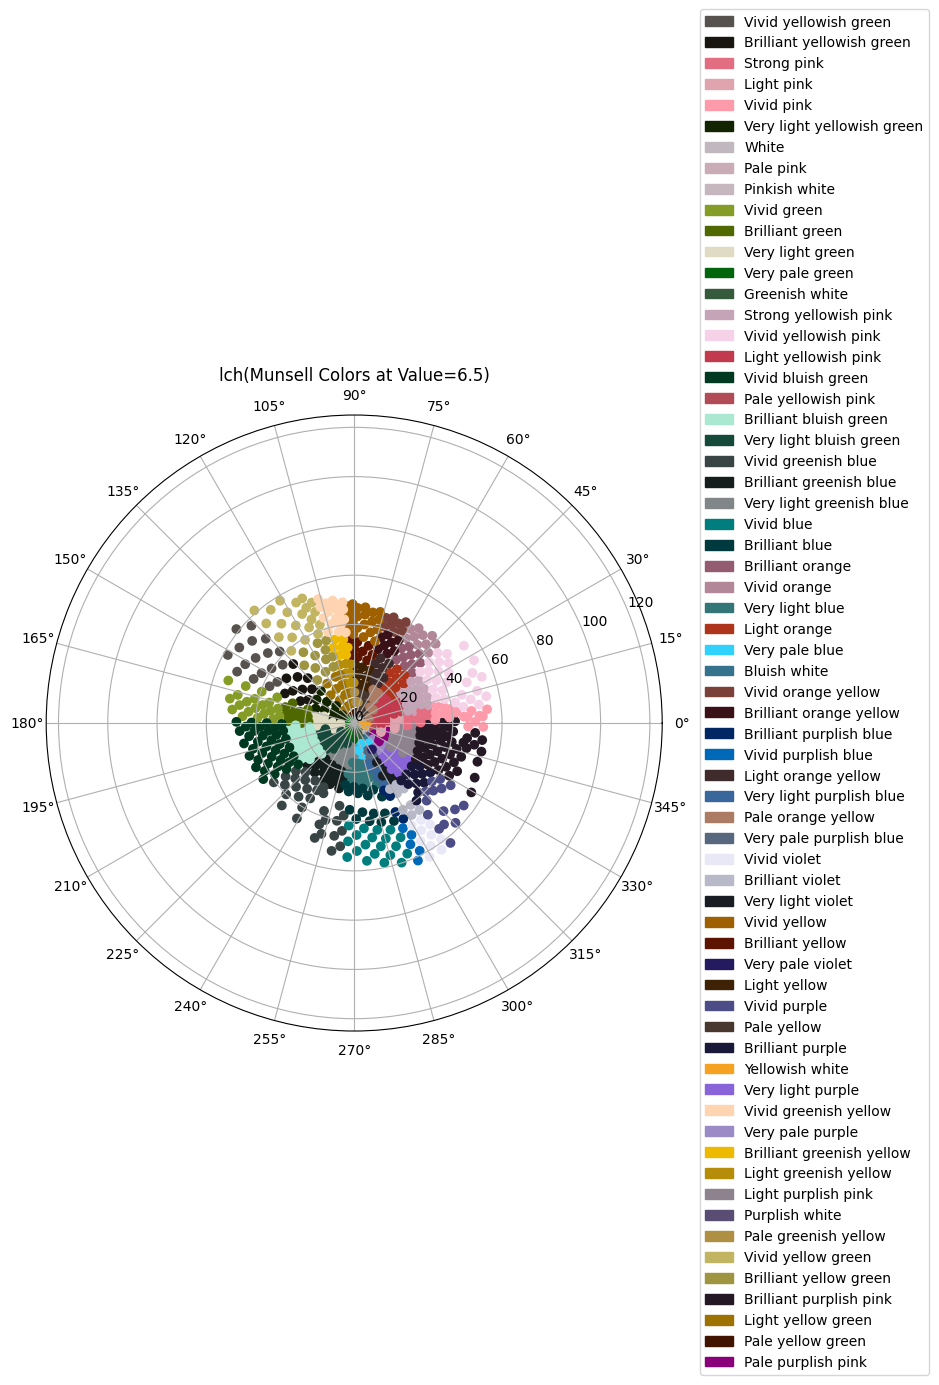

In [205]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import colour
import munsell
import itertools

from ISCC_NBS_renotations import munsell_to_lch
from ISCC_NBS_renotations import lch_to_polar

lch_colors_to_plot = [munsell_to_lch(c) for c in colors_to_plot]
theta, r = zip(*[lch_to_polar(x) for x in lch_colors_to_plot])

ids = [colordb.get_descriptor_from_munsell(x).id for x in colors_to_plot]
unique_ids = list(set(ids))
color_map = [munsell_to_rgbstr(colordb.get_level3_colors()[id].centroid_color) for id in colordb.get_level3_colors().keys()]
color_labels = [colordb.get_level3_colors()[id].name for id in unique_ids]
color_patches = [mpatches.Patch(color=color_map[unique_ids[i]], label=color_labels[i]) for i in range(0, len(unique_ids))]

color_mapping = [color_map[id] for id in ids]

fig = plt.figure(figsize=[8.0, 8.0])
ax = fig.add_subplot(projection='polar')
ax.set_xticks(np.arange(0, 2*np.pi, np.pi/ (360.0 / 30.0) ))
#ax.set_xticks(xtick_minor_ticks, labels=xtick_minor_labels, minor=True)
ax.set_yticks(np.arange(0, 140.0, 20.0))
ax.set_title("lch(Munsell Colors at Value=6.5)")
ax.set_ylim(0, 125)
angle = np.deg2rad(0)
ax.legend(handles=color_patches, loc="center left", bbox_to_anchor=(.55 + np.cos(angle)/2, .55 + np.sin(angle)/2))
c = ax.scatter(theta, r, c=color_mapping)

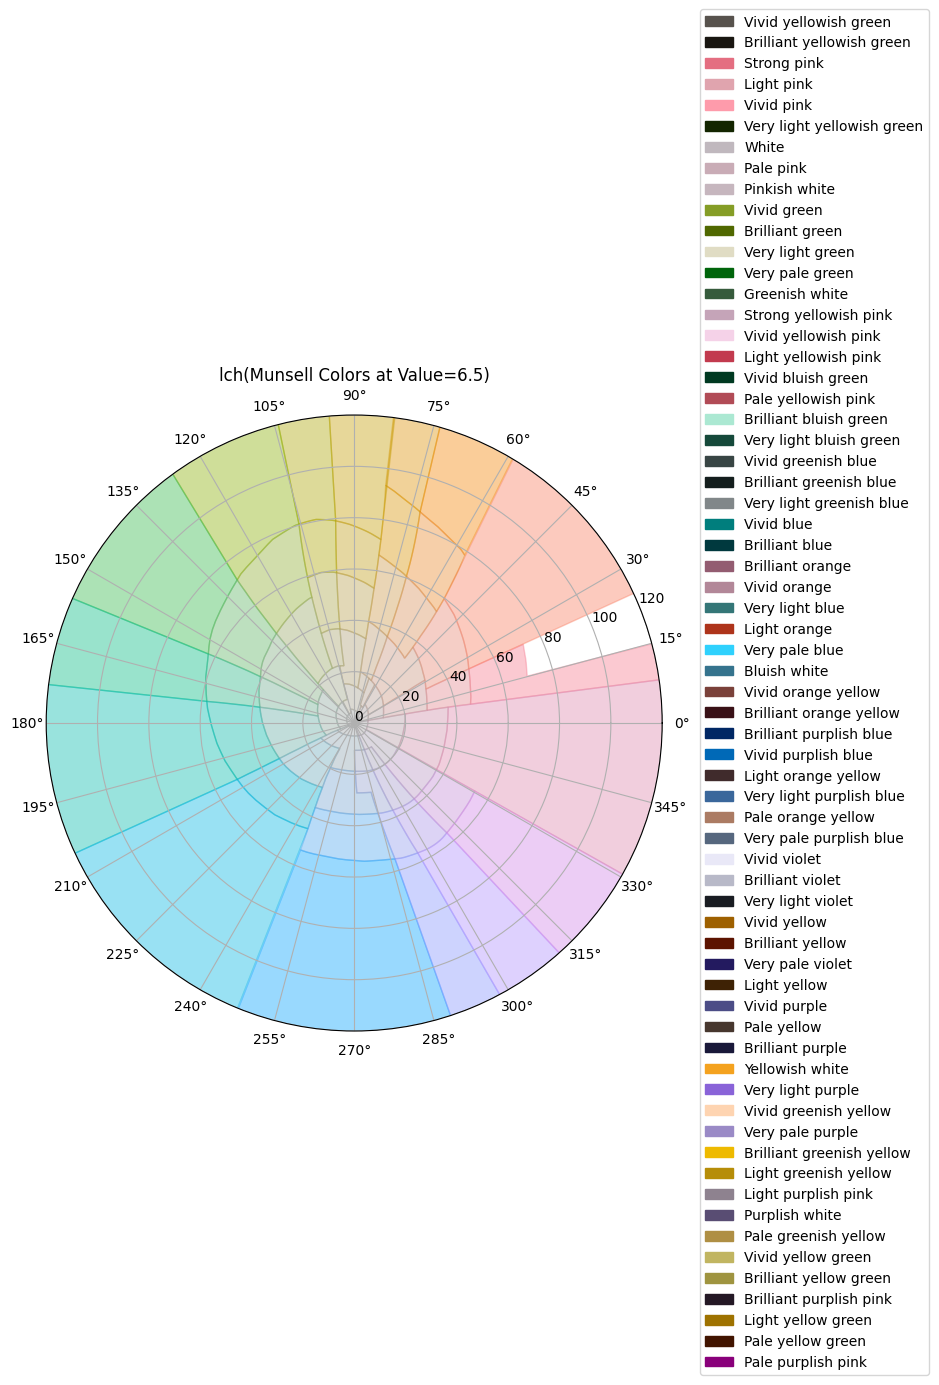

In [475]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon as PolygonShape
from shapely.ops import unary_union

from ISCC_NBS_renotations import lch_to_rgb
from ISCC_NBS_renotations import lch_to_polar
from ISCC_NBS_renotations import munsell_to_lch
from ISCC_NBS_renotations import point_to_hue_and_code

# can we put some blocks behind it?

def block_point_to_vert(hp, v, c):
    hue, hue_code = point_to_hue_and_code(hp)
    is_outside_edge = True if c >= 20.0 else False
    if is_outside_edge:
        c = 20.0
    m = munsell_specification_to_munsell_colour([hue, v, c, hue_code])
    lch = munsell_to_lch(m)
    # we want to project this out to "infinity" for purposes of the graph
    if is_outside_edge:
        lch[1] = 2000.0
    return lch_to_polar(lch)

def color_point(hp, v, c):
    hue, hue_code = point_to_hue_and_code(hp)
    is_outside_edge = True if c >= 20.0 else False
    if is_outside_edge:
        c = 20.0
    m = munsell_specification_to_munsell_colour([hue, v, c, hue_code])
    return munsell_to_rgbstr(m)    

VALUE = 6.5

fig = plt.figure(figsize=[8.0, 8.0])
ax = fig.add_subplot(projection='polar')
ax.set_xticks(np.arange(0, 2*np.pi, np.pi/ (360.0 / 30.0) ))
#ax.set_xticks(xtick_minor_ticks, labels=xtick_minor_labels, minor=True)
ax.set_yticks(np.arange(0, 140.0, 20.0))
ax.set_title("lch(Munsell Colors at Value={})".format(VALUE))
ax.set_ylim(0, 120)
angle = np.deg2rad(0)
ax.legend(handles=color_patches, loc="center left", bbox_to_anchor=(.55 + np.cos(angle)/2, .55 + np.sin(angle)/2))

def get_polygon_vertices(m):
    hue_end = m.hue_end
    if hue_end < m.hue_begin:
        hue_end += 100.0
    chroma_end = m.chroma_end
    if chroma_end > 1000.0:
        chroma_end = 1000.0

    top    = [(m.hue_begin, x)    for x in np.linspace(m.chroma_begin, chroma_end, 10)]
    left   = [(x, m.chroma_begin) for x in np.linspace(hue_end, m.hue_begin, 10)]
    bottom = [(hue_end, x)        for x in np.linspace(chroma_end, m.chroma_begin, 10)]
    right  = [(x, chroma_end)     for x in np.linspace(m.hue_begin, hue_end, 10)]

    out = top + right + bottom + left
    return out

def add_background_polygons(plt, blocks, xfrm_func, color_func):
    combined_ranges = {}
    for m in blocks:
        new_p = PolygonShape(get_polygon_vertices(m))
        if m.id in combined_ranges:
            union_p = unary_union([combined_ranges[m.id], new_p])
            if union_p.geom_type == 'MultiPolygon':
                # oops! this one's probably over the 100.0->0.0 crossing
                x1 = combined_ranges[m.id].exterior.coords[0][0]
                if x1 < 50.0:
                    new_p = PolygonShape([(c[0] - 100.0, c[1]) for c in new_p.exterior.coords])
                else:
                    new_p = PolygonShape([(c[0] + 100.0, c[1]) for c in new_p.exterior.coords])
                union_p = unary_union([combined_ranges[m.id], new_p])
            combined_ranges[m.id] = union_p
        else:
            combined_ranges[m.id] = new_p

    for id in combined_ranges.keys():
        verts = [xfrm_func(c[0], c[1]) for c in combined_ranges[id].exterior.coords]
        hue = combined_ranges[id].centroid.x
        chroma = combined_ranges[id].centroid.y
        # if this is one of the "out-to-infinity" points, bring it way back in for purposes
        # of doing the color conversion
        if chroma > 400.0:
            chroma = np.min([xy[1] for xy in combined_ranges[id].exterior.coords]) * 1.1
        x, y = zip(*verts)
        plt.fill(
            x, y,
            color=color_func(hue, chroma),
            alpha=0.4
        )

add_background_polygons(
    plt,
    filter(lambda m: m.value_begin <= VALUE and VALUE < m.value_end, colordb.get_color_ranges()),
    lambda h, c: block_point_to_vert(h, VALUE, c),
    lambda h, c: color_point(h, VALUE, c)
)

plt.show()


merge ColorMatch(6, 1.0, 4.0, 5.5, 6.5, 5.0, 7.0) with ColorMatch(6, 4.0, 6.0, 5.5, 6.5, 5.0, 7.0)
is now ColorMatch(6, 1.0, 6.0, 5.5, 6.5, 5.0, 7.0)
merge ColorMatch(11, 1.0, 4.0, 5.5, 6.5, 15.0, inf) with ColorMatch(11, 4.0, 6.0, 5.5, 6.5, 15.0, inf)
is now ColorMatch(11, 1.0, 6.0, 5.5, 6.5, 15.0, inf)
merge ColorMatch(18, 1.0, 4.0, 5.5, 6.5, 1.5, 5.0) with ColorMatch(18, 4.0, 6.0, 5.5, 6.5, 1.5, 5.0)
is now ColorMatch(18, 1.0, 6.0, 5.5, 6.5, 1.5, 5.0)
merge ColorMatch(22, 1.0, 4.0, 4.5, 6.5, 0.5, 1.5) with ColorMatch(22, 4.0, 6.0, 4.5, 6.5, 0.5, 1.5)
is now ColorMatch(22, 1.0, 6.0, 4.5, 6.5, 0.5, 1.5)
merge ColorMatch(265, 1.0, 4.0, 4.5, 6.5, 0.0, 0.5) with ColorMatch(265, 4.0, 6.0, 4.5, 6.5, 0.0, 0.5)
is now ColorMatch(265, 1.0, 6.0, 4.5, 6.5, 0.0, 0.5)
merge ColorMatch(11, 1.0, 6.0, 5.5, 6.5, 15.0, inf) with ColorMatch(11, 6.0, 7.0, 5.5, 6.5, 15.0, inf)
is now ColorMatch(11, 1.0, 7.0, 5.5, 6.5, 15.0, inf)
merge ColorMatch(18, 1.0, 6.0, 5.5, 6.5, 1.5, 5.0) with ColorMatch(18, 6.0, 

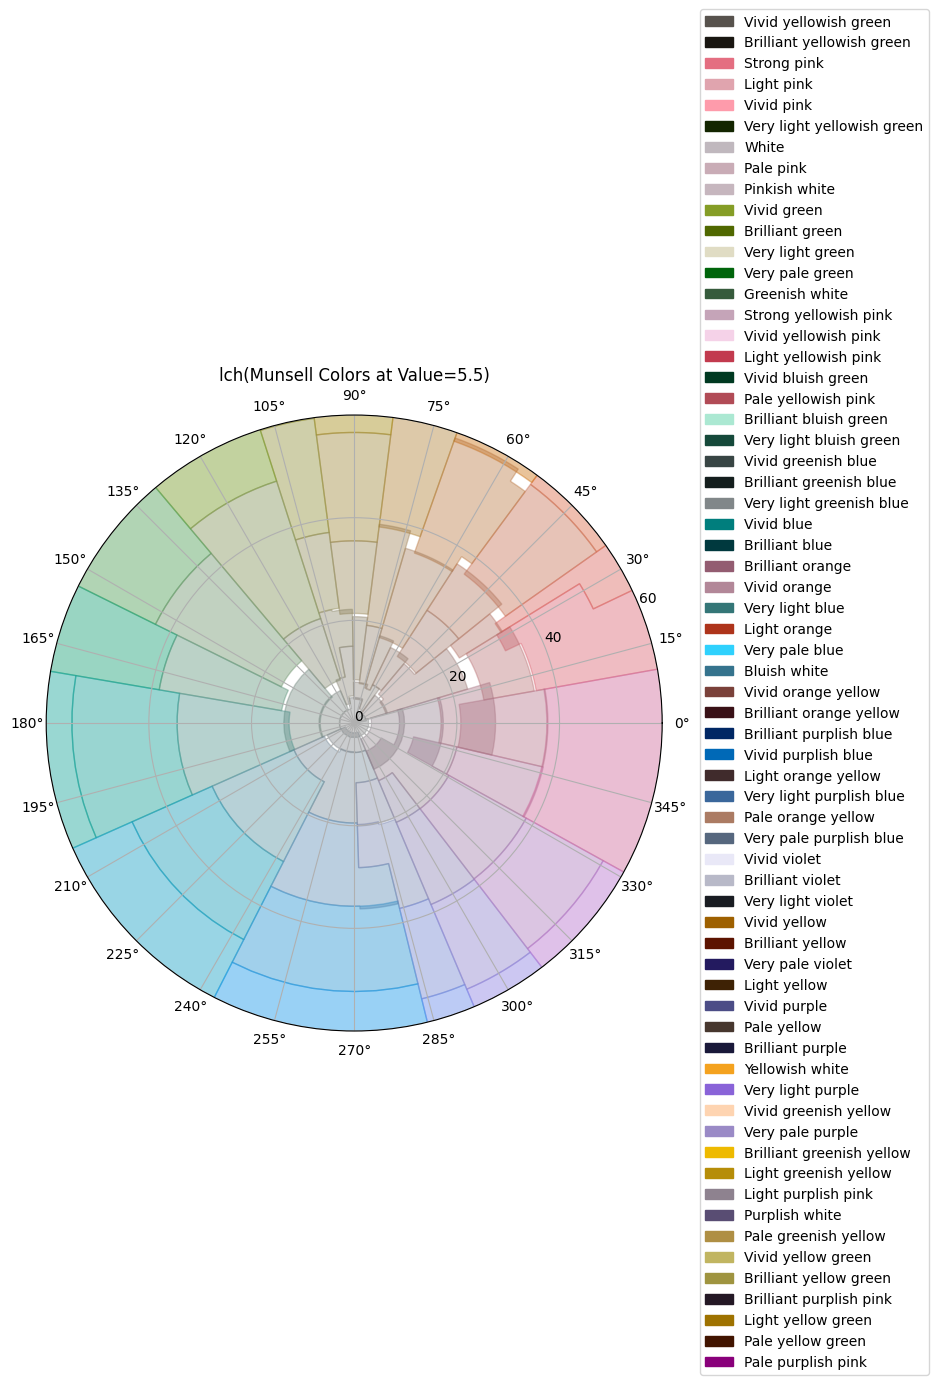

In [503]:
# Let's do two things

from ISCC_NBS_renotations import hue_point_average
from colordb import ColorMatch

VALUE = 5.5

def lch_for_hue_point(hue_point, value, chroma):
    hue, hue_code = point_to_hue_and_code(hue_point)
    munsell_string = munsell_specification_to_munsell_colour([hue, value, chroma, hue_code])
    lch = munsell_to_lch(munsell_string)
    return lch

def get_average_lab_hue_for_munsell_hue_point(hp, value):
    huex = 0.0
    huey = 0.0
    samples = 0
    for c in np.arange(1.0, 16.0, 0.5):
        lch = lch_for_hue_point(hp, v, c)
        huex += math.cos(np.deg2rad(lch[2]))
        huey += math.sin(np.deg2rad(lch[2]))
        samples += 1
    hue_angle_degrees = np.rad2deg(math.atan2((huey / samples), (huex / samples)))
    return (hue_angle_degrees + 360) % 360

def get_hue_remap_table_for_value(value):
    hue_points = set()

    # figure out what hues we need to tweak
    for m in filter(lambda m: m.value_begin <= VALUE and VALUE < m.value_end, colordb.get_color_ranges()):
        hue_points.add(m.hue_begin)
        hue_points.add(m.hue_end)

    remap_table = {}
    for hp in hue_points:
        remap_table[hp] = get_average_lab_hue_for_munsell_hue_point(hp, value)
    return remap_table

def munsell_block_to_lch_block(remap_table, b, value):
    average_hp = hue_point_average(b.hue_begin, b.hue_end)

    chroma_begin = b.chroma_begin
    chroma_end = b.chroma_end
    
    is_outside_edge = True if chroma_end >= 20.0 else False
    if is_outside_edge:
        chroma_end = 20.0
    
    lch_begin = lch_for_hue_point(average_hp, value, chroma_begin)
    lch_end = lch_for_hue_point(average_hp, value, chroma_end)

    if is_outside_edge:
        lch_end[1] = 2000.0

    # add_background_polygons all assumes this is on a 100pt scale
    hue_begin = remap_table[b.hue_begin] * 100.0 / 360.0
    hue_end = remap_table[b.hue_end] * 100.0 / 360.0

    return ColorMatch(b.id,
                      hue_begin=hue_begin, hue_end=hue_end,
                      value_begin=lch_begin[0], value_end=lch_end[0],
                      chroma_begin=lch_begin[1], chroma_end=lch_end[1])

def bg_xfrm_func(h, c):
    return (h * math.pi / 50.0, c)

def bg_color_func(h, c):
    lch = (VALUE * 10, c, h * 360.0 / 100.0)
    Lab = colour.LCHab_to_Lab(lch)
    XYZ = colour.Lab_to_XYZ(Lab)
    sRGB = colour.XYZ_to_sRGB(XYZ)
    return colour.notation.RGB_to_HEX(sRGB) 

def same_chroma(a, b):
    return ((a.chroma_begin == b.chroma_begin) and
            (a.chroma_end == b.chroma_end or
             math.isinf(a.chroma_end) and math.isinf(b.chroma_end)))

def combine_blocks_by_hue(block_list):
    new_block_list = []
    for block in block_list:
        add_this_block = True
        for existing_block in new_block_list:

            # merge with matching ids and matching chroma
            # we don't need to match by values because we've already pulled that out
            #    existing_block.value_begin == block.value_begin and
            #    existing_block.value_end == block.value_end and

            if (existing_block.id == block.id and same_chroma(existing_block, block)):
                if (existing_block.hue_end == block.hue_begin):
                    print("merge {} with {}".format(existing_block, block))
                    existing_block.hue_end = block.hue_end
                    print("is now {}".format(existing_block))
                    add_this_block = False
                elif (existing_block.hue_begin == block.hue_end):
                    print("merge {} with {}".format(existing_block, block))
                    existing_block.hue_begin = block.hue_begin
                    print("[wrap] is now {}".format(existing_block))
                    add_this_block = False

        if add_this_block:
            new_block_list.append(block.copy())

    return new_block_list

blocks_for_value = [b for b in filter(lambda m: m.value_begin <= VALUE and VALUE < m.value_end, colordb.get_color_ranges())]
blocks_for_value = combine_blocks_by_hue(blocks_for_value)
remap_table = get_hue_remap_table_for_value(VALUE)
new_blocks = [munsell_block_to_lch_block(remap_table, b, VALUE) for b in blocks_for_value]

fig = plt.figure(figsize=[8.0, 8.0])
ax = fig.add_subplot(projection='polar')
ax.set_xticks(np.arange(0, 2*np.pi, np.pi/ (360.0 / 30.0) ))
#ax.set_xticks(xtick_minor_ticks, labels=xtick_minor_labels, minor=True)
ax.set_yticks(np.arange(0, 140.0, 20.0))
ax.set_title("lch(Munsell Colors at Value={})".format(VALUE))
ax.set_ylim(0, 60)
angle = np.deg2rad(0)
ax.legend(handles=color_patches, loc="center left", bbox_to_anchor=(.55 + np.cos(angle)/2, .55 + np.sin(angle)/2))

add_background_polygons(plt, new_blocks, bg_xfrm_func, bg_color_func)

plt.show()


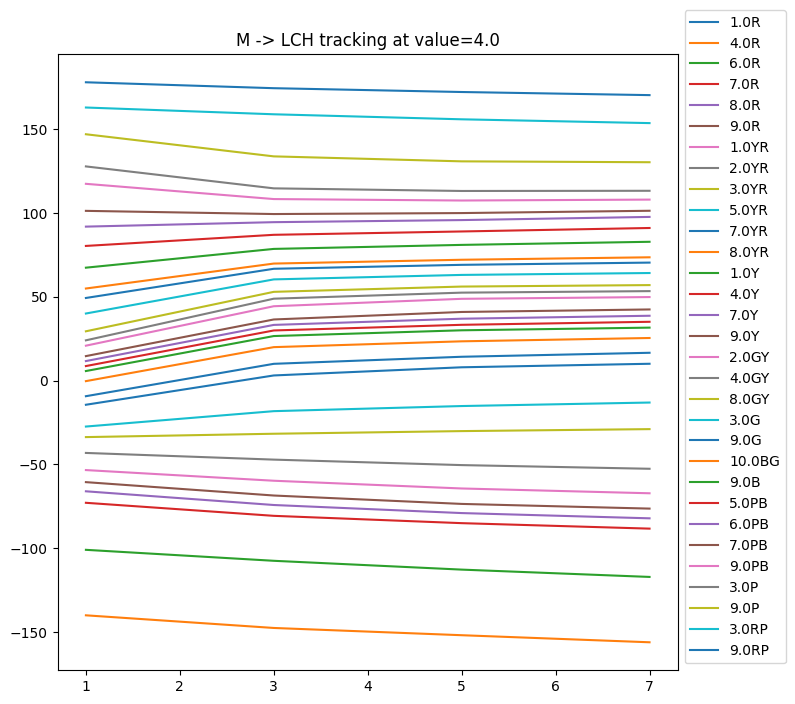

In [420]:
# First, we want to take the hue boundaries

from ISCC_NBS_renotations import point_to_hue_and_code, munsell_hue_point_name

def lch_for_hue_point(hue_point, value, chroma):
    hue, hue_code = point_to_hue_and_code(hue_point)
    munsell_string = munsell_specification_to_munsell_colour([hue, value, chroma, hue_code])
    lch = munsell_to_lch(munsell_string)
    return lch

fig = plt.figure(figsize=[8.0, 8.0])
ax = fig.add_subplot()
ax.set_title("LCH Hues based on value for Selected Munsell Hues"))

for hp in colordb.get_hue_points():
    data = []
    for v in np.arange(1.0, 9.0, 0.5):        
        huex = 0.0
        huey = 0.0
        samples = 0
        
        for c in np.arange(1.0, 16.0, 0.5):
            lch = lch_for_hue_point(hp, v, c)
            huex += math.cos(np.deg2rad(lch[2]))
            huey += math.sin(np.deg2rad(lch[2]))
            samples += 1

        hue_angle_degrees = np.rad2deg(math.atan2((huey / samples), (huex / samples)))
        data.append(hue_angle_degrees)

    x = np.arange(1.0, 9.0, 2.0)
    y = data
    ax.plot(x, y, label='{}'.format(munsell_hue_point_name(hp)))
    #print("hi")

ax.legend(loc="lower left", bbox_to_anchor=(1, 0))
plt.show()

value=1.0, chroma=1.0: offset = 4.07151436412123, factor = 3.379420539458865
value=1.0, chroma=2.0: offset = 8.193679871088408, factor = 6.616481720107771
value=1.0, chroma=3.0: offset = 12.283303365873342, factor = 9.952890345673788
value=1.0, chroma=4.0: offset = 16.450323267326645, factor = 13.530465079113021
value=1.0, chroma=5.0: offset = 20.442261899879206, factor = 16.499140885089417
value=1.0, chroma=6.0: offset = 24.546365301790225, factor = 20.095190801082822
value=1.0, chroma=7.0: offset = 28.592968046357175, factor = 22.661085449953436
value=1.0, chroma=8.0: offset = 32.80493505604726, factor = 26.441239756765206
value=1.0, chroma=9.0: offset = 36.6071506835245, factor = 30.345032734517794
value=1.0, chroma=10.0: offset = 40.57828921192155, factor = 34.991632528250385
value=1.0, chroma=11.0: offset = 44.42098165643663, factor = 37.27212273787939
value=1.0, chroma=12.0: offset = 48.451082209581166, factor = 39.28740595769083
value=1.0, chroma=13.0: offset = 52.36906365492692

value=9.0, chroma=2.0: offset = 8.193679871088408, factor = 6.616481720107771
value=9.0, chroma=3.0: offset = 12.283303365873342, factor = 9.952890345673788
value=9.0, chroma=4.0: offset = 16.450323267326645, factor = 13.530465079113021
value=9.0, chroma=5.0: offset = 20.442261899879206, factor = 16.499140885089417
value=9.0, chroma=6.0: offset = 24.546365301790225, factor = 20.095190801082822
value=9.0, chroma=7.0: offset = 28.592968046357175, factor = 22.661085449953436
value=9.0, chroma=8.0: offset = 32.80493505604726, factor = 26.441239756765206
value=9.0, chroma=9.0: offset = 36.6071506835245, factor = 30.345032734517794
value=9.0, chroma=10.0: offset = 40.57828921192155, factor = 34.991632528250385
value=9.0, chroma=11.0: offset = 44.42098165643663, factor = 37.27212273787939
value=9.0, chroma=12.0: offset = 48.451082209581166, factor = 39.28740595769083
value=9.0, chroma=13.0: offset = 52.369063654926926, factor = 42.68096519295106


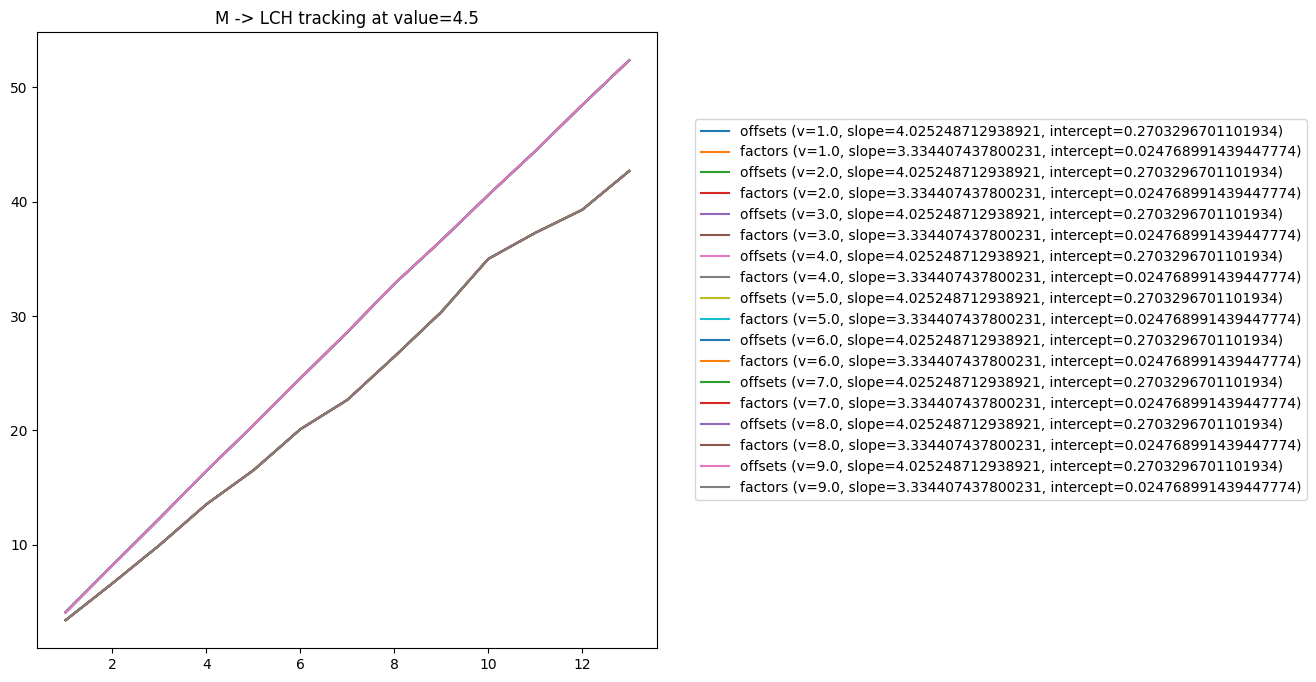

In [126]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import scipy

from ISCC_NBS_renotations import lch_to_rgb
from ISCC_NBS_renotations import lch_to_polar
from ISCC_NBS_renotations import munsell_to_lch
from ISCC_NBS_renotations import point_to_hue_and_code

VALUE = 4.5

fig = plt.figure(figsize=[8.0, 8.0])
ax = fig.add_subplot()
#ax.set_xticks(np.arange(0, 2*np.pi, np.pi/ (360.0 / 30.0) ))
#ax.set_xticks(xtick_minor_ticks, labels=xtick_minor_labels, minor=True)
#ax.set_yticks(np.arange(0, 140.0, 20.0))
ax.set_title("M -> LCH tracking at value={}".format(VALUE))
#ax.set_ylim(-100, 100)

def lch_for_hue_point(hue_point, value, chroma):
    hue, hue_code = point_to_hue_and_code(hue_point)
    munsell_string = munsell_specification_to_munsell_colour([hue, VALUE, chroma, hue_code])
    lch = munsell_to_lch(munsell_string)
    return lch

for value in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    plot1 = []
    plot2 = []

    for chroma in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]: #np.arange(1.0, 18.0, 1.0):
        xy = [lch_to_polar(lch_for_hue_point(hp, value, chroma)) for hp in np.linspace(0.0, 100.0, 100)]
        theta, r = zip(*xy)
        scale_offset = np.min(r)
        scale_factor = np.max(r) - np.min(r)
        #r = scale_to_0_1(r)
        #theta = np.linspace(0.0, 100.0, 100)
        print("value={}, chroma={}: offset = {}, factor = {}".format(value, chroma, scale_offset, scale_factor))
        plot1.append((chroma, scale_offset))
        plot2.append((chroma, scale_factor))

    chromas, offsets = zip(*plot1)
    reg = scipy.stats.linregress(chromas, offsets)
    ax.plot(chromas, offsets, label='offsets (v={}, slope={}, intercept={})'.format(value, reg.slope, reg.intercept))
    chromas, factors = zip(*plot2)
    reg = scipy.stats.linregress(chromas, factors)
    ax.plot(chromas, factors, label='factors (v={}, slope={}, intercept={})'.format(value, reg.slope, reg.intercept))
    

angle = np.deg2rad(0)
ax.legend(loc="center left", bbox_to_anchor=(.55 + np.cos(angle)/2, .55 + np.sin(angle)/2))

plt.show()


new best coeff = (-16.0, -2.0, -1.0, -2.0, -0.5, -1.0), error = 16.313642168822376
the good ones: coeff = (-16.0, -2.0, -1.0, -2.0, -0.5, -1.0), error = 16.313642168822376


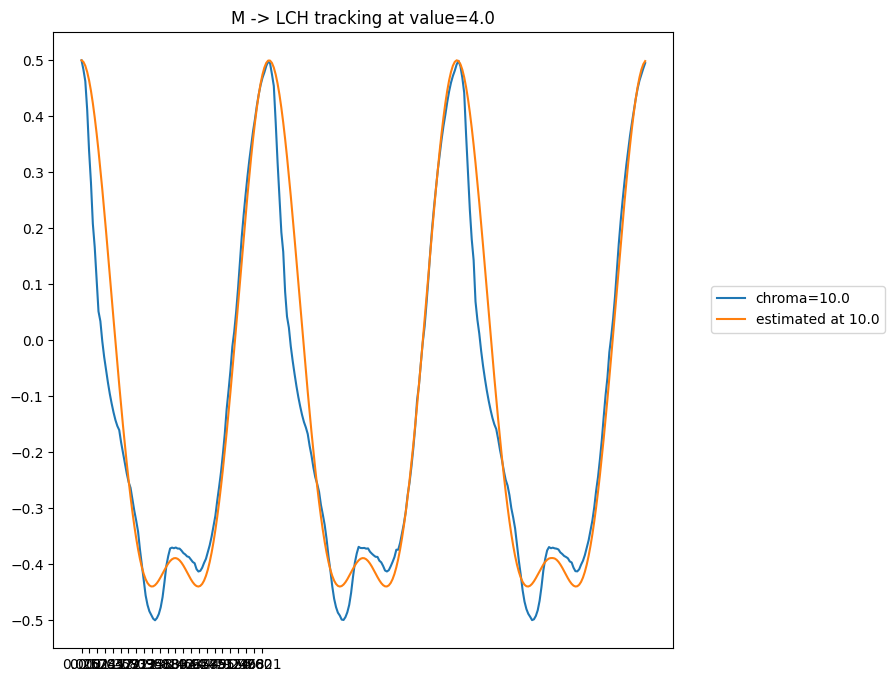

In [395]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import itertools
import numpy as np
import scipy

from ISCC_NBS_renotations import lch_to_rgb
from ISCC_NBS_renotations import lch_to_polar
from ISCC_NBS_renotations import munsell_to_lch
from ISCC_NBS_renotations import point_to_hue_and_code

VALUE = 4.0

fig = plt.figure(figsize=[8.0, 8.0])
ax = fig.add_subplot() #projection='polar')
ax.set_xticks(np.arange(0, 2*np.pi, np.pi/ (360.0 / 30.0) ))
#ax.set_xticks(xtick_minor_ticks, labels=xtick_minor_labels, minor=True)
#ax.set_yticks(np.arange(0, 140.0, 20.0))
ax.set_yticks(np.linspace(-0.5, 0.5, 11))
ax.set_title("M -> LCH tracking at value={}".format(VALUE))
#ax.set_ylim(-100, 100)

def lch_for_hue_point(hue_point, value, chroma):
    hue, hue_code = point_to_hue_and_code(hue_point)
    munsell_string = munsell_specification_to_munsell_colour([hue, VALUE, chroma, hue_code])
    lch = munsell_to_lch(munsell_string)
    return lch

dctavg = None
dctavg_n = 0

def scale_to_0_1(ar):
    return (ar - np.min(ar))/(np.max(ar) - np.min(ar))

def put_max_first(r):
    peak_index = np.argmax(r)
    r = np.concatenate((r[peak_index:len(r)], r[0:peak_index]))
    return r

for chroma in [10.0]: #np.arange(1.0, 18.0, 1.0):
    xy = [lch_to_polar(lch_for_hue_point(hp, VALUE, chroma)) for hp in np.linspace(0.0, 300.0, 300)]
    theta, r = zip(*xy)
    theta = np.linspace(0.0, 6*math.pi, 300)

    scale_offset = np.min(r)
    scale_factor = np.max(r) - np.min(r)
    r = scale_to_0_1(r) - 0.5
    
    #ax.plot(theta, r, label='chroma={}'.format(chroma))

ideal_r = r
peak_index = np.argmax(ideal_r)
ideal_r = np.concatenate((ideal_r[peak_index:len(ideal_r)], ideal_r[0:peak_index]))
#ax.plot(theta, ideal_r, label='chroma={}'.format(chroma))

    
def test_plot(hp, value, chroma):
    theta = ((hp) * (np.pi / 50.0)) % (2 * np.pi)
    #r = (math.sin(theta + (math.pi * 1.25))) * (1 - (theta / (2 * math.pi)))
    #r = math.cos((theta + -math.sin(theta * 2)) * 2)
    x = theta + math.pi * 1.0
    r = (-32.0*math.cos(x*-2 + math.sin(x)*0.0) + -0.125*math.cos(x*-0.0625 - math.sin(x)*0.0)) / ((-32 + -0.125)*2)
    #r = np.sinc((theta * 0.5) - math.pi * 0.6) - 0.5
    #r = (r * 0.5) + 0.5
    return (theta, r)

# (-32.0, -0.125, -2.0, -0.0625, 0.0, 0.0, 1.0) ?
def test_plot2(hp, value, chroma, coeff):
    theta = ((hp) * (np.pi / 50.0)) % (2 * np.pi)
    #r = (math.sin(theta + (math.pi * 1.25))) * (1 - (theta / (2 * math.pi)))
    #r = math.cos((theta + -math.sin(theta * 2)) * 2)
    x = theta + math.pi
    if (coeff[0]+coeff[1]) == 0:
        r = 200
    else:
        r = (coeff[0]*math.cos(x*coeff[2] + math.sin(x)*coeff[4]) + coeff[1]*math.cos(x*coeff[3] - math.sin(x)*coeff[5])) / ((coeff[0]+coeff[1])*2)
    #r = np.sinc((theta * 0.5) - math.pi * 0.6) - 0.5
    #r = (r * 0.5) + 0.5
    return (theta, r)


def value_6_5_match(hp, value, chroma):
    theta = ((hp) * (np.pi / 50.0)) % (2 * np.pi)
    x = theta + -0.6*math.pi
    r = (-16.0*math.cos(-x + -math.sin(x)/2) + -2.0*math.cos(x/16 - math.sin(x)*4)) / ((-16.0+-2.0)*2)
    return (theta, r)

#xy = [test_plot(hp, VALUE, 10.0) for hp in np.linspace(0.0, 200.0, 200)]
#theta, r = zip(*xy)
#theta = np.linspace(0.0, 4*math.pi, 200)

powers_of_two = [1, 2, 4, 8, 16]
coeff_choices = np.concatenate(([x for x in powers_of_two], [1/x for x in powers_of_two]))
coeff_choices = np.concatenate((coeff_choices, -coeff_choices, [0]))
coeff_choices.sort()
min_error = None
min_error_coeffs = None

# for coeff in [(-8.0, -0.125, -0.125, -0.125, 4.0, 2.0)]:
# for coeff in [(-16.0, -2.0, -1.0, -0.0625, -0.5, 4.0)]:
#for coeff in itertools.product(coeff_choices, coeff_choices, coeff_choices, coeff_choices, coeff_choices, coeff_choices):
for coeff in [(-16.0, -2.0, -1.0, -2.0, -0.5, -1.0),
              #(-16.0, -2.0, -1.0, -0.25, -0.5, -8.0),
              #(-16.0, -0.5, -1.0, -0.25, -0.5, -8.0)
             ]:
    # drop anything with obvious discontinuities
    if np.abs(test_plot2(99.0, VALUE, 10.0, coeff)[1] - test_plot2(100.0, VALUE, 10.0, coeff)[1]) > 0.1:
        continue
    
    xy = [test_plot2(hp, VALUE, 10.0, coeff) for hp in np.linspace(0.0, 300.0, 300)]
    theta, r = zip(*xy)

    r = put_max_first(r)    
    diff = np.abs(r - ideal_r)
    rel_error = np.sum(diff)

    if min_error is None or min_error > rel_error:
        min_error = rel_error
        min_error_coeffs = coeff
        print("new best coeff = {}, error = {}".format(coeff, rel_error))

for chroma in [10.0]: #np.arange(1.0, 18.0, 1.0):
    xy = [lch_to_polar(lch_for_hue_point(hp, VALUE, chroma)) for hp in np.linspace(0.0, 300.0, 300)]
    theta, r = zip(*xy)
    theta = np.linspace(0.0, 6*math.pi, 300)

    scale_offset = np.min(r)
    scale_factor = np.max(r) - np.min(r)
    r = scale_to_0_1(r) - 0.5
    
    #ax.plot(theta, r, label='chroma={}'.format(chroma))

theta = np.linspace(0.0, 6*math.pi, 300)
ax.plot(theta, ideal_r, label='chroma={}'.format(chroma))

print("the good ones: coeff = {}, error = {}".format(min_error_coeffs, min_error))
xy = [test_plot2(hp, VALUE, 10.0, coeff) for hp in np.linspace(0.0, 300.0, 300)]
theta, r = zip(*xy)
r = put_max_first(r)
theta = np.linspace(0.0, 6*math.pi, 300)
ax.plot(theta, r, label='estimated at {}'.format(chroma))

    

angle = np.deg2rad(0)
ax.legend(loc="center left", bbox_to_anchor=(.55 + np.cos(angle)/2, .55 + np.sin(angle)/2))

plt.show()